## Compressing Data via Dimensionality Reduction :

An alternative approach to feature selection for dimensionality reduction is feature extraction.

In this chapter, we will cover the following topics:

• Principal component analysis for **unsupervised** data compression

• Linear discriminant analysis as a **supervised** dimensionality reduction technique for maximizing
class separability

• A brief overview of nonlinear dimensionality reduction techniques and t-distributed stochastic neighbor embedding for data visualization

## Unsupervised dimensionality reduction via principal component analysis :

The difference between feature selection and feature extraction is that while
we maintain the original features when we use feature selection algorithms, such as sequential backward
selection, we use feature extraction to transform or project the data onto a new feature space.

feature
extraction is not only used to improve storage space or the computational efficiency of the learning
algorithm but can also improve the predictive performance by reducing the **curse of dimensionality**—
especially if we are working with non-regularized models.

## principal component analysis:
unsupervised linear transformation
technique

PCA helps us to identify patterns in data based on the correlation between features.

PCA
aims to find the directions of maximum variance in high-dimensional data and projects the data onto
a new subspace with equal or fewer dimensions than the original one.

The orthogonal axes (principal
components) of the new subspace can be interpreted as the directions of maximum variance given
the constraint that the new feature axes are orthogonal to each other

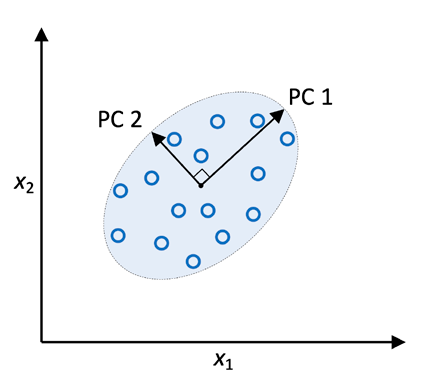

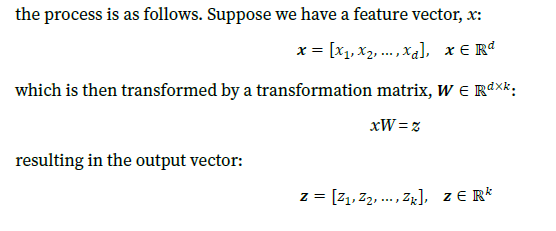

the first principal component will have the largest possible variance.

All consequent
principal components will have the largest variance given the constraint that these components are
uncorrelated (orthogonal) to the other principal components—even if the input features are correlated,
the resulting principal components will be mutually orthogonal (uncorrelated). Note that the PCA
directions are highly sensitive to data scaling, and we need to standardize the features prior to PCA if
the features were measured on different scales and we want to assign equal importance to all features.

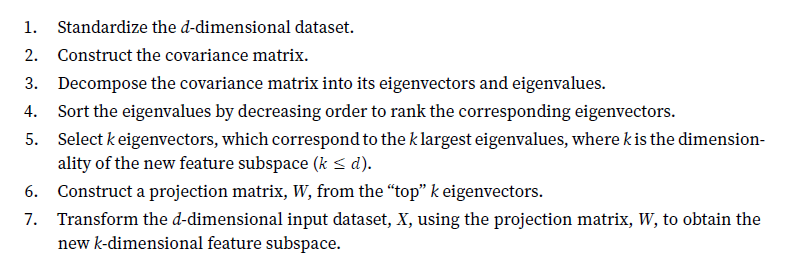


Eigenvectors → directions (new axes)

Eigenvalues → how much variance exists along each direction

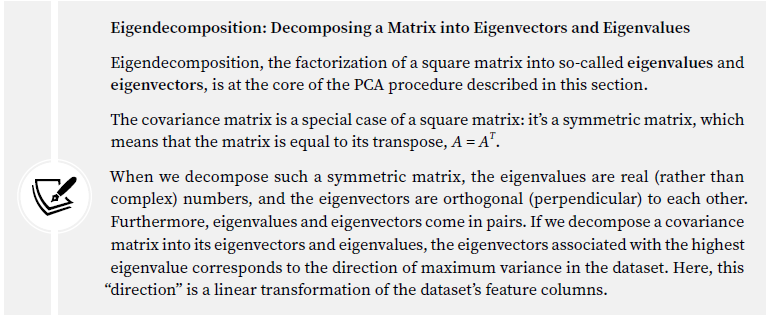

In [ ]:
# 1. Standardizing the data
# 2. Constructing the covariance matrix
# 3. Obtaining the eigenvalues and eigenvectors of the covariance matrix
# 4. Sorting the eigenvalues by decreasing order to rank the eigenvectors
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [2]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, 
                     stratify=y,
                     random_state=0)

In [3]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

the covariance between two features, xj and xk

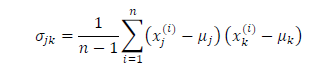

Note that the sample means
are zero if we standardized the dataset.

A positive covariance between two features indicates that
the features increase or decrease together, whereas a negative covariance indicates that the features
vary in opposite directions.

The eigenvectors of the covariance matrix represent the principal components (the directions of
maximum variance)whereas the corresponding eigenvalues will define their magnitude

In [ ]:
import numpy as np
cov_mat = np.cov(X_train_std.T) #expects each row to be a variable (feature), so we transpose.
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n', eigen_vals)

#eigen_vals   # 1D array
#eigen_vecs   # 2D matrix



Eigenvalues 
 [4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


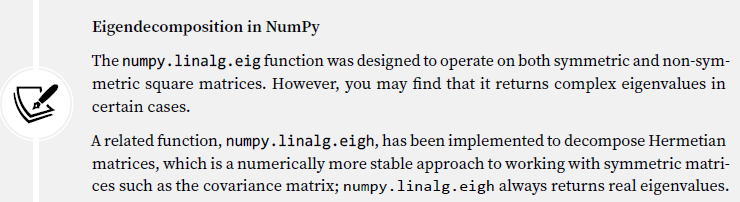

Since we want to reduce the dimensionality of our dataset by compressing it onto a new feature subspace,
we only select the subset of the eigenvectors (principal components) that contains most of the
information (variance). The eigenvalues define the magnitude of the eigenvectors, so we have to sort the
eigenvalues by decreasing magnitude; we are interested in the top k eigenvectors based on the values
of their corresponding eigenvalues.

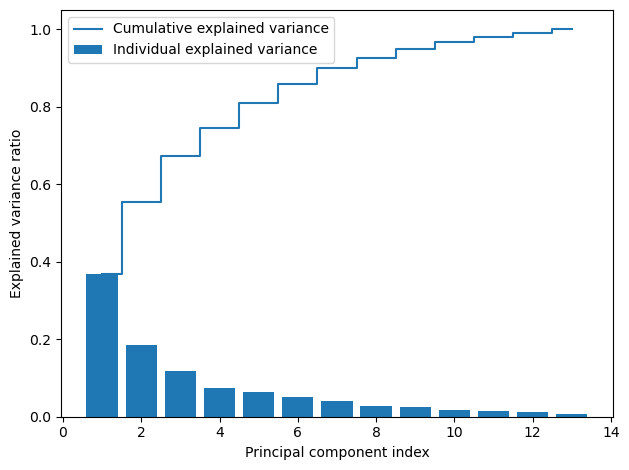

In [5]:
#plot the variance explained ratios of the eigenvalues.
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt


plt.bar(range(1, 14), var_exp, align='center',
        label='Individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

we should remind
ourselves that PCA is an unsupervised method, which means that information about the class labels
is ignored. Whereas a random forest uses the class membership information to compute the node
impurities, variance measures the spread of values along a feature axis.

## Feature transformation :

1. Select k eigenvectors, which correspond to the k largest eigenvalues, where k is the dimensionality
of the new feature subspace (𝑘𝑘 𝑘 𝑘𝑘 ).
2. Construct a projection matrix, W, from the “top” k eigenvectors.
3. Transform the d-dimensional input dataset, X, using the projection matrix, W, to obtain the
new k-dimensional feature subspace.

In [6]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [ ]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)
#By executing the preceding code, we have created a 13×2-dimensional projection matrix, W, from thetop two eigenvectors

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


In [8]:
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

In [9]:
X_train_pca = X_train_std.dot(w)

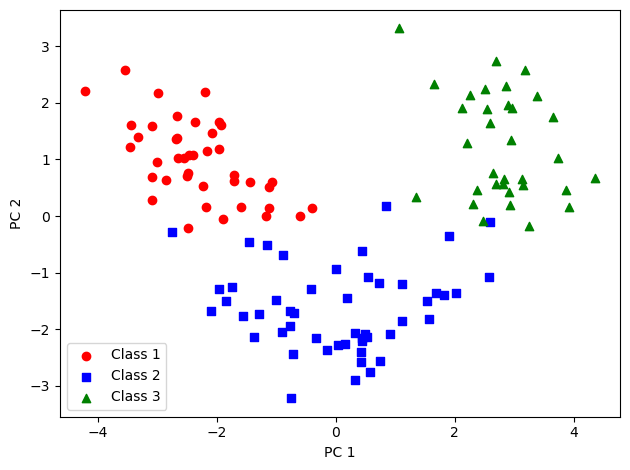

In [10]:
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=f'Class {l}', marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('figures/05_03.png', dpi=300)
plt.show()

we have to keep in mind that PCA is an unsupervised technique that doesn’t use any class
label information.

## Principal component analysis in scikit-learn :


In [11]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

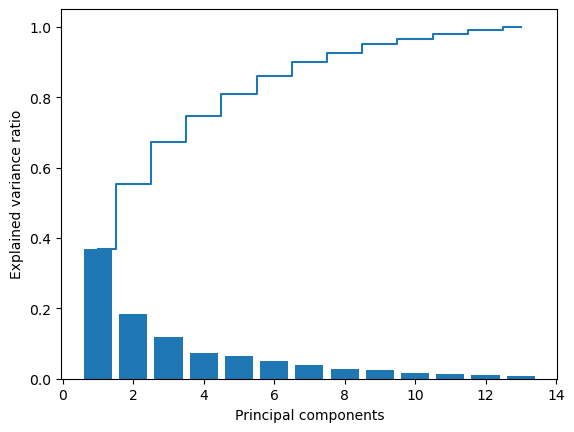

In [12]:
plt.bar(range(1, 14), pca.explained_variance_ratio_, align='center')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

In [13]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

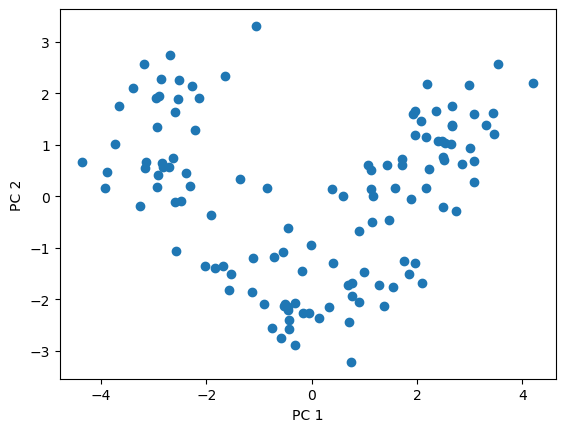

In [14]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [15]:

from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

In [16]:
from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_pca, y_train)

c:\Users\Dell\anaconda3\envs\mlbook\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


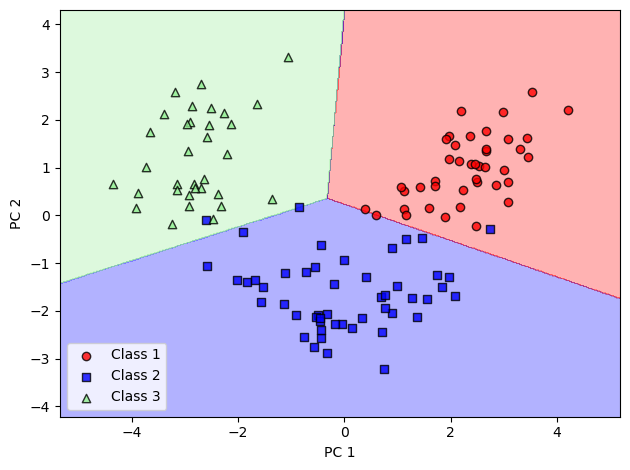

In [17]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('figures/05_04.png', dpi=300)
plt.show()

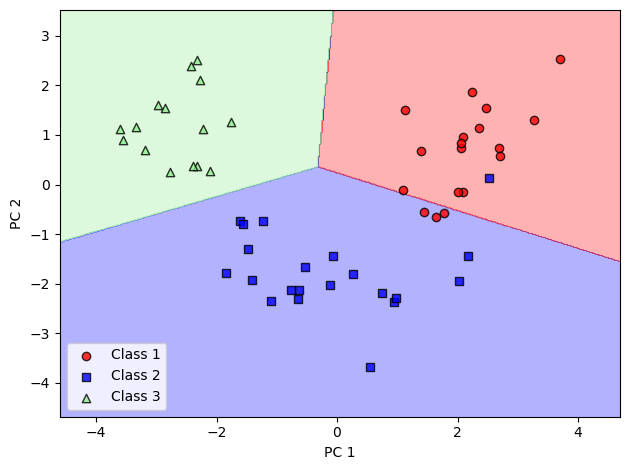

In [18]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('figures/05_05.png', dpi=300)
plt.show()

In [19]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

Note that we set n_components=None when we initialized the PCA class so that it will return all principal
components in a sorted order, instead of performing a dimensionality reduction.

## Assessing feature contributions:
we are interested to know about how much each original
feature contributes to a given principal component. These contributions are often called **loadings**.

The factor loadings can be computed by scaling the eigenvectors by the square root of the eigenvalues The resulting values can then be interpreted as the correlation between the original features and
the principal component.

In [20]:
loadings = eigen_vecs * np.sqrt(eigen_vals)

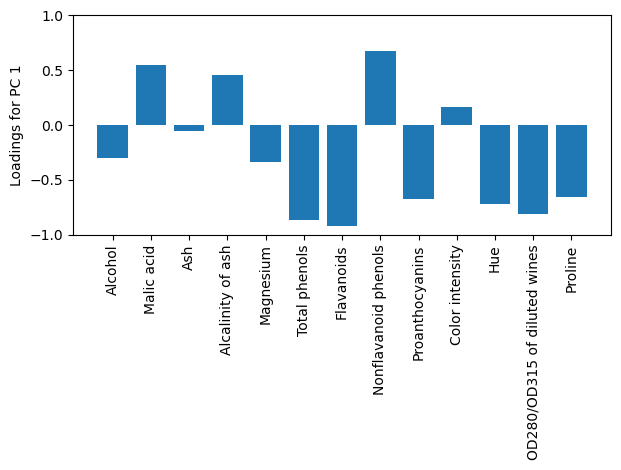

In [22]:
fig, ax = plt.subplots()

ax.bar(range(13), loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)

plt.ylim([-1, 1])
plt.tight_layout()

plt.show()

Alcohol has a negative correlation with the first principal 
component whereas Malic acid has a positive correlation (approximately 0.54).
Note that a value of 1 describes a perfect positive correlation whereas a value of –1 corresponds to a
perfect negative correlation

In [23]:
#where pca.components_ represents the eigenvectors and pca.explained_variance_ represents the eigenvalues

sklearn_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

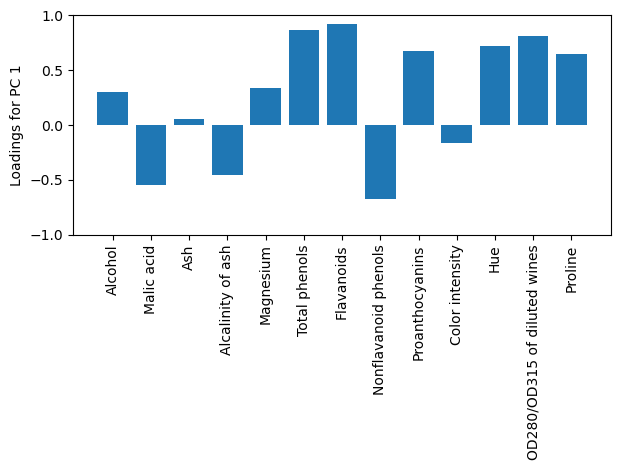

In [25]:
fig, ax = plt.subplots()

ax.bar(range(13), sklearn_loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)

plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

## Supervised data compression via linear discriminant analysis :

linear discriminant analysis (LDA), which is a linear transformation technique that takes class label
information into account.

LDA can be used as a technique for **feature extraction** to increase computational efficiency and reduce
the degree of overfitting due to the curse of dimensionality in non-regularized models

The general
concept behind LDA is very similar to PCA, but whereas PCA attempts to find the orthogonal component
axes of maximum variance in a dataset, the goal in LDA is to find the feature subspace that optimizes
class separability.

**Why can PCA outperform LDA in some cases?**

When the dataset has few samples per class:
LDA needs to estimate class statistics (means & covariance)With little data, these estimates become unstable This can cause overfitting

PCA, on the other hand:

Does not rely on class labels
Captures the most important global patterns
Is often more robust when data is limited


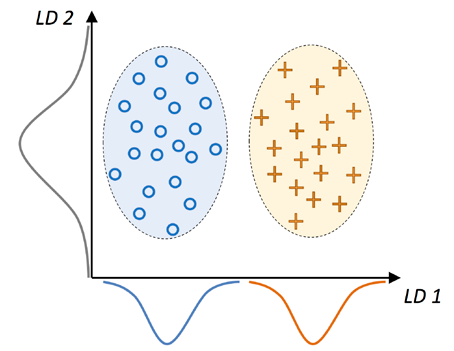


## Principal component analysis versus linear discriminant analysis:

Both PCA and LDA are linear transformation techniques that can be used to reduce the number of dimensions
in a dataset

LDA is a superior feature extraction technique for classification tasks compared
to PCA

**Within-class scatter matrix (SW):**
Measures how much samples vary inside each class
Small values mean samples of a class are tightly clustered

**Between-class scatter matrix (SB)**

Measures how far class means are from each other
Large values mean classes are well separated

**Goal of LDA:**

Minimize within-class scatter and maximize between-class scatter

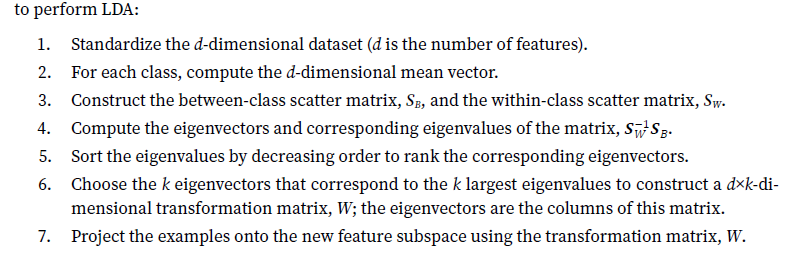

LDA takes class label information into account,which is represented in the form
of the mean vectors computed in step 2





Since we already standardized the features of the Wine dataset in the PCA section at the beginning of
this chapter, we can skip the first step and proceed with the calculation of the mean vectors

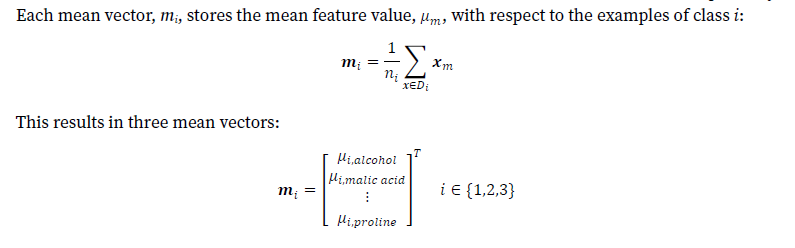

In [1]:
np.set_printoptions(precision=4) #display numbers with 4 decimal places

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0)) #axis 0 = column-wise mean
    print(f'MV {label}: {mean_vecs[label - 1]}\n')

NameError: name 'np' is not defined

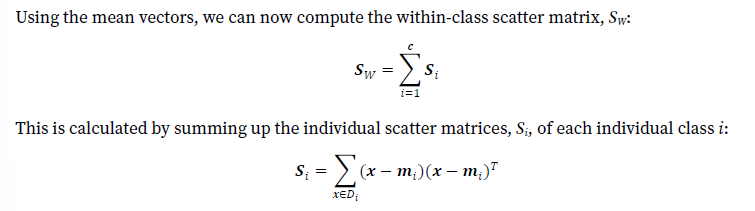

In [ ]:
d = 13 # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  # scatter matrix for each class
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # make column vectors
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter                          # sum class scatter matrices

print('Within-class scatter matrix: '
      f'{S_W.shape[0]}x{S_W.shape[1]}')

Within-class scatter matrix: 13x13


The assumption that we are making when we are computing the scatter matrices is that the class labels
in the training dataset are uniformly distributed. However, if we print the number of class labels, we
see that this assumption is violated:

In [ ]:

print('Class label distribution:',  
      np.bincount(y_train)[1:])

Class label distribution: [41 50 33]


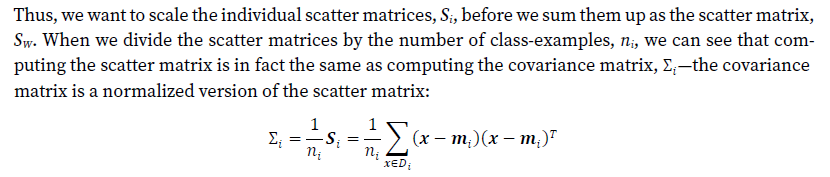 


Better: covariance matrix since classes are not equally distributed:

## Normalizing by class size:

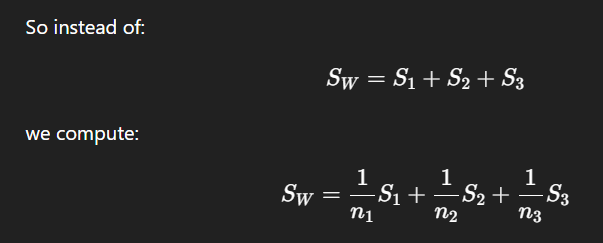

This way, each class contributes equally to the total within-class scatter, regardless of how many samples it has.

This equation should look familiar — it’s exactly how we compute the covariance matrix for a class.

So, when we scale each scatter matrix by its number of samples, we’re essentially computing the covariance matrix of each class.

In [29]:
d = 13  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
    
print('Scaled within-class scatter matrix: '
      f'{S_W.shape[0]}x{S_W.shape[1]}')

Scaled within-class scatter matrix: 13x13


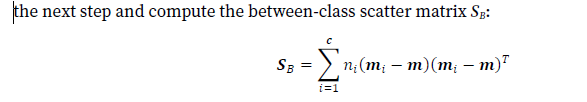

Here, m is the overall mean that is computed, including examples from all c classes:

In [ ]:
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)  # make column vector

d = 13  # number of features
S_B = np.zeros((d, d))

for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0] #Counts how many samples belong to the current class
    mean_vec = mean_vec.reshape(d, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: '
      f'{S_B.shape[0]}x{S_B.shape[1]}')

Between-class scatter matrix: 13x13


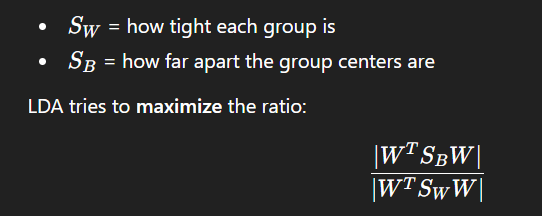

## Selecting linear discriminants for the new feature subspace:

In [31]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))


In [32]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

349.61780890599397
172.76152218979385
3.220958741966256e-14
3.220958741966256e-14
2.6106523402387364e-14
1.703897776458183e-14
1.703897776458183e-14
1.687554433463065e-14
1.687554433463065e-14
7.584950171788759e-15
2.941210515518115e-15
2.941210515518115e-15
0.0


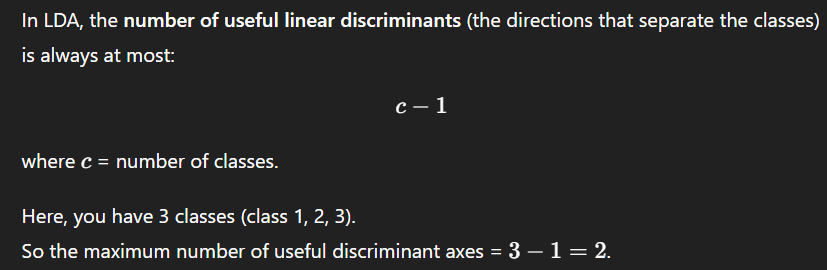

Collinearity happens when some features (or data points) are linearly dependent —
in other words, one feature can be expressed as a linear combination of others.

Note that in the rare case of perfect collinearity (all aligned example points fall on a
straight line), the covariance matrix would have rank one, which would result in only one
eigenvector with a nonzero eigenvalue.

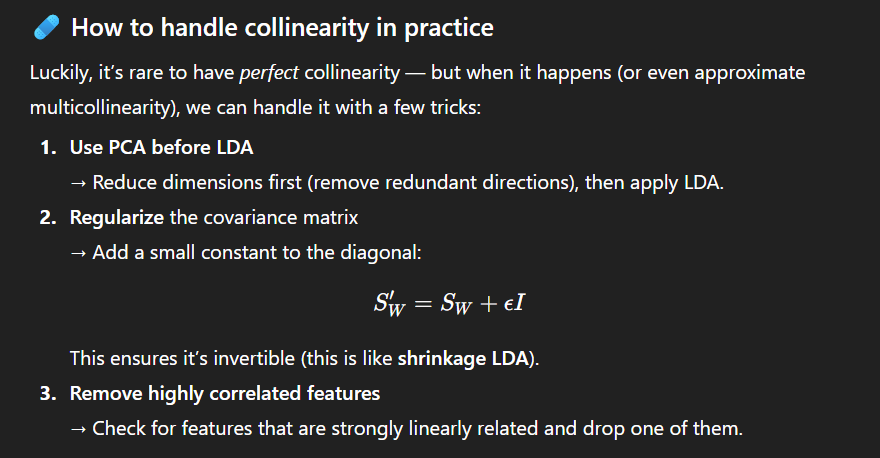

how much of the class-discriminatory information is captured by the linear discriminants
(eigenvectors)

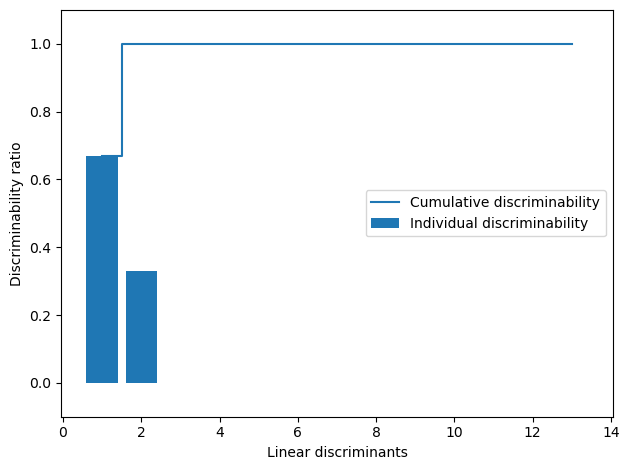

In [33]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, align='center',
        label='Individual discriminability')
plt.step(range(1, 14), cum_discr, where='mid',
         label='Cumulative discriminability')
plt.ylabel('Discriminability ratio')
plt.xlabel('Linear discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('figures/05_07.png', dpi=300)
plt.show()

In [34]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


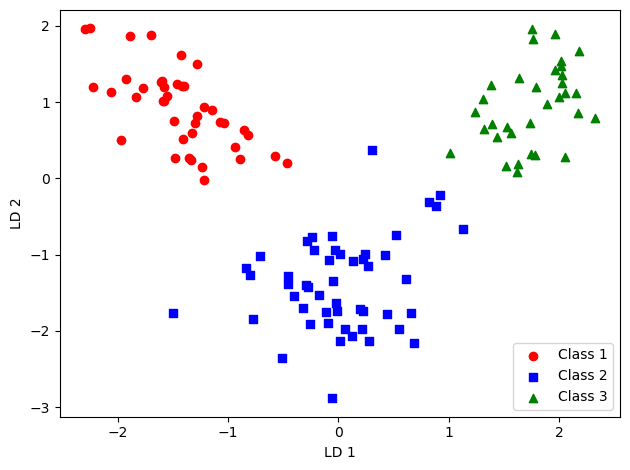

In [36]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=f'Class {l}', marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## LDA via scikit-learn:



In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

c:\Users\Dell\anaconda3\envs\mlbook\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


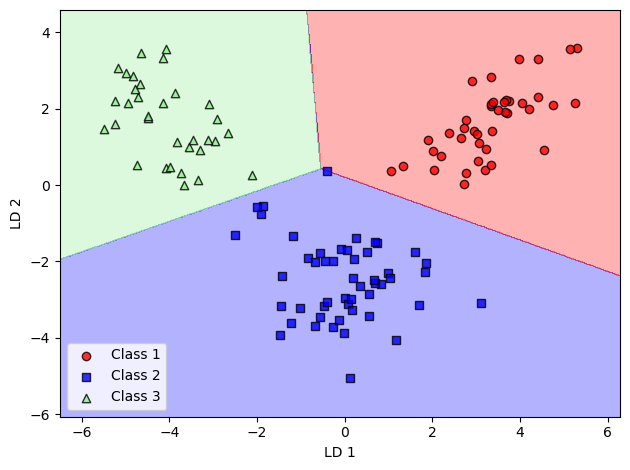

In [39]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('figures/05_09.png', dpi=300)
plt.show()

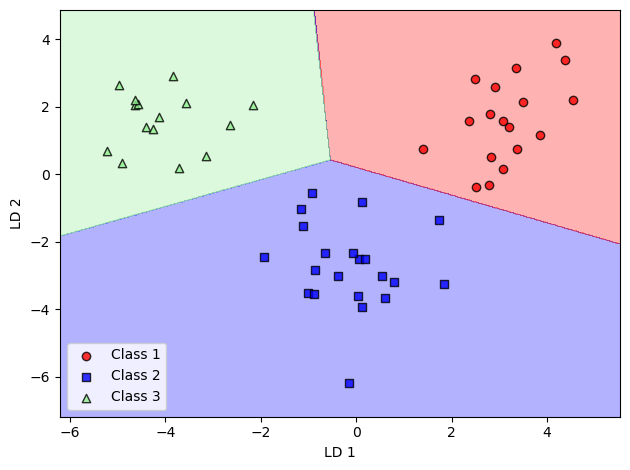

In [40]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('figures/05_10.png', dpi=300)
plt.show()

## Nonlinear dimensionality reduction and visualization :
we will discuss why considering nonlinear dimensionality reduction
techniques might be worthwhile.

One nonlinear dimensionality reduction technique that is particularly worth highlighting is t-distributed
stochastic neighbor embedding (t-SNE)

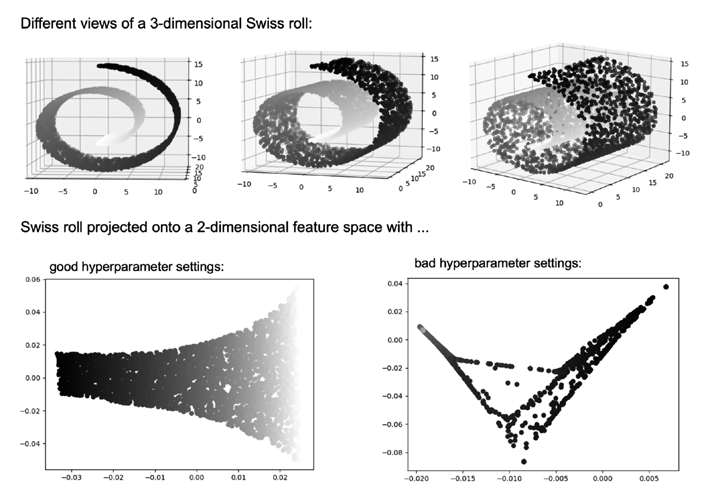

The development and application of nonlinear dimensionality reduction techniques is also often
referred to as manifold learning, where a manifold refers to a lower dimensional topological space
embedded in a high-dimensional space. Algorithms for manifold learning have to capture the complicated
structure of the data in order to project it onto a lower-dimensional space where the relationship
between data points is preserved.


While nonlinear dimensionality reduction and manifold learning algorithms are very powerful, we
should note that these techniques are notoriously hard to use, and with non-ideal hyperparameter
choices, they may cause more harm than good


## Visualizing data via t-distributed stochastic neighbor embedding
In a nutshell, t-SNE is modeling data points based on their pair-wise distances in the high-dimensional
(original) feature space.Then, it finds a probability distribution of pair-wise distances in the
new, lower-dimensional space that is close to the probability distribution of pair-wise distances in the
original space.

Or, in other words, t-SNE learns to embed data points into a lower-dimensional space
such that the pairwise distances in the original space are preserved.

t-SNE is a technique intended for
visualization purposes as it requires the whole dataset for the projection.Since it projects the points
directly (unlike PCA, it does not involve a projection matrix), we cannot apply t-SNE to new data points.

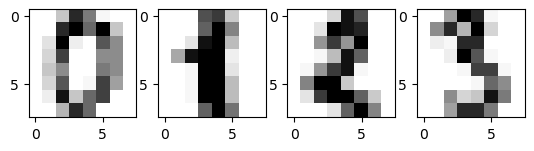

In [41]:
from sklearn.datasets import load_digits

digits = load_digits()

fig, ax = plt.subplots(1, 4)

for i in range(4):
    ax[i].imshow(digits.images[i], cmap='Greys')
    
# plt.savefig('figures/05_12.png', dpi=300)
plt.show() 

In [42]:
digits.data.shape

(1797, 64)

In [43]:

y_digits = digits.target
X_digits = digits.data

In [44]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2,
            init='pca',
            random_state=123)
X_digits_tsne = tsne.fit_transform(X_digits)

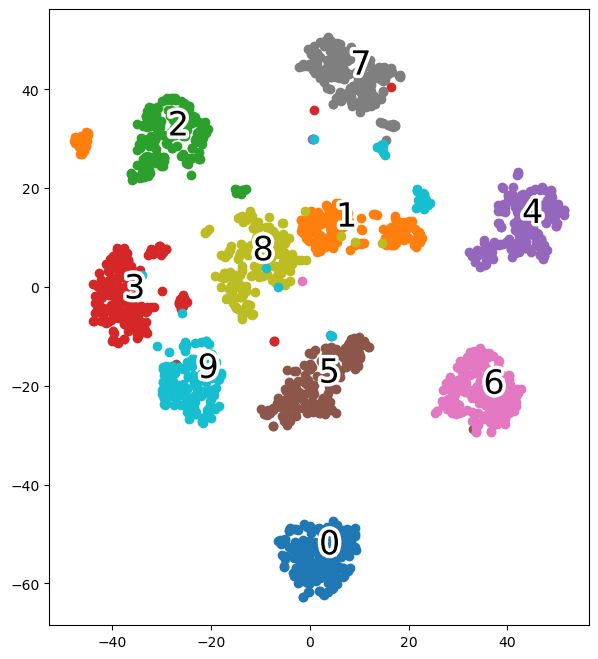

In [45]:
import matplotlib.patheffects as PathEffects


def plot_projection(x, colors):
    
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    for i in range(10):
        plt.scatter(x[colors == i, 0],
                    x[colors == i, 1])

    for i in range(10):

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        
plot_projection(X_digits_tsne, y_digits)
# plt.savefig('figures/05_13.png', dpi=300)
plt.show()

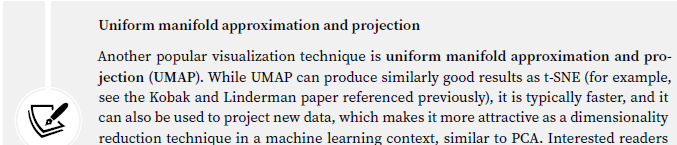